In [8]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D,GRU
from keras.layers import Dropout, Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
import numpy as np
import pandas as pd

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11813512978395717930
xla_global_id: -1
]


In [3]:
EMBEDDING_FILE = "/mnt/c/Users/lokes/Downloads/glove.840B.300d.txt"
train = pd.read_csv("/mnt/c/Users/lokes/Downloads/train.tsv",delimiter="\t").fillna(" ")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/lokes/Downloads/train.tsv'

In [4]:
max_features = 100000
maxlen = 150
embed_size=300

In [5]:
train.head()

,PID,Text_data,Label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate


In [6]:
train["Label"].value_counts()

moderate          6019
not depression    1971
severe             901
Name: Label, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train["Label"] = le.fit_transform(train["Label"])

In [8]:
train["Label"].value_counts()

0    6019
1    1971
2     901
Name: Label, dtype: int64

In [9]:
train.head()

,PID,Text_data,Label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,0
1,train_pid_2,My new years resolution : I'm gonna get my ass...,0
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,0
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",0
4,train_pid_5,Sat in the dark and cried myself going into th...,0


In [10]:
df=train[0:901]
df2=train[6019:6920]
df3=train[7990:]

df = df[['Text_data', 'Label']]
df2 = df2[['Text_data', 'Label']]
df3 = df3[['Text_data', 'Label']]

print("Moderate cases: ", str(len(df)))
print("Not Depressed cases: ", str(len(df2)))
print("Severe cases: ", str(len(df3)))

data = pd.concat([df, df2, df3], axis=0).reset_index(drop=True)

Moderate cases:  901
Not Depressed cases:  901
Severe cases:  901


In [11]:
train_x = data["Text_data"].str.lower()
train_y = data["Label"]
train_y = pd.get_dummies(train_y,columns=train_y).values
train_y.shape

(2703, 3)

In [12]:
tokenizer = text.Tokenizer(num_words=max_features,lower=True)
tokenizer.fit_on_texts(list(train_x))

In [13]:
train_x = tokenizer.texts_to_sequences(train_x)
train_x = sequence.pad_sequences(train_x,maxlen=maxlen)

In [14]:
embedding_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
    for line in f:
        values = line.strip().rsplit(" ")
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embedding_index[word] = coefs

In [15]:
word_index = tokenizer.word_index
num_words = min(len(word_index)+1,max_features)
embedding_matrix = np.zeros((num_words,embed_size))

for word, i in word_index.items():
    if i>=max_features:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Basic N network

In [17]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.35)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.15))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2022-03-18 21:17:19.374406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-18 21:17:19.447792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-18 21:17:19.448234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-18 21:17:19.449730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the app

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

In [ ]:
new_complaint =['not feeling happy']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = sequence.pad_sequences(seq, maxlen=maxlen, truncating='post', padding='post')
pred = model.predict(padded)
labels = ['moderate','not depression','severe']
print("Prediction:  ",pred,"\n\tLabel:  ", labels[np.argmax(pred)])

Prediction:   [[0.53601277 0.4157318  0.0482555 ]] 
	Label:   moderate


# conv layer tuning 

2 conv layers and changing number of neurons


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.35)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.15))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)
x = Conv1D(128,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 9s 64ms/step - loss: 0.8206 - accuracy: 0.6119
Epoch 2/5
85/85 [==============================] - 5s 62ms/step - loss: 0.4557 - accuracy: 0.8272
Epoch 3/5
85/85 [==============================] - 5s 57ms/step - loss: 0.2710 - accuracy: 0.9149
Epoch 4/5
85/85 [==============================] - 5s 56ms/step - loss: 0.1873 - accuracy: 0.9393
Epoch 5/5
85/85 [==============================] - 5s 64ms/step - loss: 0.1210 - accuracy: 0.9586


3 conv layers

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.35)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.15))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)
x = Conv1D(128,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)
x = Conv1D(256,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 9s 63ms/step - loss: 0.8412 - accuracy: 0.6030
Epoch 2/5
85/85 [==============================] - 5s 57ms/step - loss: 0.5107 - accuracy: 0.7969
Epoch 3/5
85/85 [==============================] - 5s 60ms/step - loss: 0.2873 - accuracy: 0.9101
Epoch 4/5
85/85 [==============================] - 5s 59ms/step - loss: 0.1972 - accuracy: 0.9364
Epoch 5/5
85/85 [==============================] - 5s 59ms/step - loss: 0.1762 - accuracy: 0.9404


# Dropout hypertuning

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.1))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 8s 60ms/step - loss: 0.8012 - accuracy: 0.6463
Epoch 2/5
85/85 [==============================] - 5s 57ms/step - loss: 0.3920 - accuracy: 0.8609
Epoch 3/5
85/85 [==============================] - 5s 61ms/step - loss: 0.2191 - accuracy: 0.9371
Epoch 4/5
85/85 [==============================] - 6s 68ms/step - loss: 0.1227 - accuracy: 0.9626
Epoch 5/5
85/85 [==============================] - 5s 62ms/step - loss: 0.0649 - accuracy: 0.9822


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.05))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 8s 65ms/step - loss: 0.7731 - accuracy: 0.6471
Epoch 2/5
85/85 [==============================] - 5s 61ms/step - loss: 0.3536 - accuracy: 0.8787
Epoch 3/5
85/85 [==============================] - 5s 61ms/step - loss: 0.1632 - accuracy: 0.9497
Epoch 4/5
85/85 [==============================] - 5s 64ms/step - loss: 0.0848 - accuracy: 0.9771
Epoch 5/5
85/85 [==============================] - 5s 59ms/step - loss: 0.0408 - accuracy: 0.9919


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 8s 64ms/step - loss: 0.9139 - accuracy: 0.5546
Epoch 2/5
85/85 [==============================] - 5s 64ms/step - loss: 0.5869 - accuracy: 0.7666
Epoch 3/5
85/85 [==============================] - 5s 62ms/step - loss: 0.4372 - accuracy: 0.8442
Epoch 4/5
85/85 [==============================] - 5s 61ms/step - loss: 0.2920 - accuracy: 0.9005
Epoch 5/5
85/85 [==============================] - 5s 59ms/step - loss: 0.1894 - accuracy: 0.9353


# Layer hypertuning

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.05))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 2s 18ms/step - loss: 0.6890 - accuracy: 0.7414
Epoch 2/5
85/85 [==============================] - 1s 16ms/step - loss: 0.2864 - accuracy: 0.9371
Epoch 3/5
85/85 [==============================] - 1s 16ms/step - loss: 0.1517 - accuracy: 0.9686
Epoch 4/5
85/85 [==============================] - 2s 18ms/step - loss: 0.0857 - accuracy: 0.9845
Epoch 5/5
85/85 [==============================] - 1s 17ms/step - loss: 0.0518 - accuracy: 0.9926


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.5)(x)
x = GRU(128,return_sequences=True,dropout=0.2)(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 4s 34ms/step - loss: 0.9527 - accuracy: 0.5224
Epoch 2/5
85/85 [==============================] - 3s 37ms/step - loss: 0.6651 - accuracy: 0.7259
Epoch 3/5
85/85 [==============================] - 3s 32ms/step - loss: 0.4706 - accuracy: 0.8291
Epoch 4/5
85/85 [==============================] - 3s 33ms/step - loss: 0.3367 - accuracy: 0.8820
Epoch 5/5
85/85 [==============================] - 3s 33ms/step - loss: 0.2543 - accuracy: 0.9175


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.1)(x)
x = LSTM(128,return_sequences=True,dropout=0.05)(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
85/85 [==============================] - 5s 39ms/step - loss: 0.7913 - accuracy: 0.6426
Epoch 2/5
85/85 [==============================] - 3s 38ms/step - loss: 0.3734 - accuracy: 0.8753
Epoch 3/5
85/85 [==============================] - 3s 38ms/step - loss: 0.1911 - accuracy: 0.9430
Epoch 4/5
85/85 [==============================] - 3s 38ms/step - loss: 0.1027 - accuracy: 0.9715
Epoch 5/5
85/85 [==============================] - 3s 38ms/step - loss: 0.0595 - accuracy: 0.9845


# Final resultant model

In [16]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words,embed_size,weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.05))(x)
x = Conv1D(64,kernel_size=3,padding='valid',kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool,max_pool])

out = Dense(3,activation='softmax')(x)

model = Model(inp,out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2022-03-19 09:10:31.479709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-19 09:10:31.551885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-19 09:10:31.552208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-19 09:10:31.553396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the app

In [17]:
batch_size = 32
epochs = 1

model.fit(train_x, train_y, batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5


2022-03-19 09:10:40.670687: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300
2022-03-19 09:10:45.002235: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-19 09:10:45.307626: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


85/85 [==============================] - 17s 46ms/step - loss: 0.7534 - accuracy: 0.6681
Epoch 2/5
85/85 [==============================] - 4s 46ms/step - loss: 0.3450 - accuracy: 0.8898
Epoch 3/5
85/85 [==============================] - 5s 54ms/step - loss: 0.1498 - accuracy: 0.9556
Epoch 4/5
85/85 [==============================] - 4s 45ms/step - loss: 0.0866 - accuracy: 0.9741
Epoch 5/5
85/85 [==============================] - 4s 44ms/step - loss: 0.0481 - accuracy: 0.9856


[[1 1 0]
 [0 1 0]
 [1 0 1]]
               precision    recall  f1-score   support

     moderate       0.50      0.50      0.50         2
not_depressed       0.50      1.00      0.67         1
       severe       1.00      0.50      0.67         2

     accuracy                           0.60         5
    macro avg       0.67      0.67      0.61         5
 weighted avg       0.70      0.60      0.60         5



<AxesSubplot:>

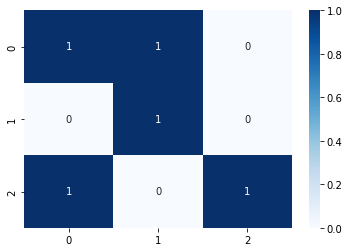

In [18]:
from sklearn import metrics

y_pred = ["moderate", "not_depressed", "severe", "moderate", "not_depressed"]

y_test = ["moderate", "not_depressed", "severe", "severe", "moderate"]

print(metrics.confusion_matrix(y_test, y_pred, labels=["moderate", "not_depressed", "severe"]))

print(metrics.classification_report(y_test, y_pred, labels=["moderate", 
"not_depressed","severe"]))

import seaborn as sns
labels = ["moderate", "not_depressed", "severe"]
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

In [19]:
new_complaint =['Life became more intolerable than before']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = sequence.pad_sequences(seq, maxlen=maxlen, truncating='post', padding='post')
pred = model.predict(padded)
labels = ['moderate','not depression','severe']
print("Prediction: ",pred)
print("     Label: ", labels[np.argmax(pred)])

Prediction:  [[0.4022895  0.5817209  0.01598955]]
     Label:  not depression
